In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# play with pd.get_dummies
df = pd.DataFrame({
    'ID': [1 ,2 ,3],
    'Category': ['A', 'B', 'A']
})
encoded_df = pd.get_dummies(df, columns=['Category'], prefix='Cat', prefix_sep='-')
print(encoded_df)

df1 = pd.DataFrame({'A': ['A0', 'A1'], 'B': ['B0', 'B1']})
df2 = pd.DataFrame({'A': ['A2', 'A3'], 'B': ['B2', 'B3']})
result_1 = pd.concat([df1, df2])
print(result_1)

df1 = pd.DataFrame({'A': ['A0', 'A1'], 'B': ['B0', 'B1']}, index=[0, 1])
df2 = pd.DataFrame({'C': ['C0', 'C1'], 'D': ['D0', 'D1']}, index=[1, 2])
result_21 = pd.concat([df1, df2], axis=1)
print(result_21)

   ID  Cat-A  Cat-B
0   1   True  False
1   2  False   True
2   3   True  False
    A   B
0  A0  B0
1  A1  B1
0  A2  B2
1  A3  B3
     A    B    C    D
0   A0   B0  NaN  NaN
1   A1   B1   C0   D0
2  NaN  NaN   C1   D1


In [4]:
data_path = 'bike_sharing_dataset/hour.csv'
rides = pd.read_csv(data_path)

# 类型变量的独热编码
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    # 独热编码，也被称为一位有效编码，其方法是使用N位状态寄存器来对N个状态进行编码，每个状态都由他独立的寄存器位来表示，并且在任意时候只有一位有效。
    # 此处务必指定dtype为int，否则默认bool，不方便torch处理
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False, dtype=int)
    rides = pd.concat([rides, dummies], axis=1) # axis=1 拼接列

# 删除原类型
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0.26,0.60,0.1642,11,108,119,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,0.26,0.60,0.1642,8,81,89,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,0.26,0.60,0.1642,7,83,90,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,0.26,0.56,0.1343,13,48,61,1,0,...,0,1,0,0,1,0,0,0,0,0


In [5]:
# 数值类型变量的处理
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}

for feature in quant_features:
    mean, std = data[feature].mean(), data[feature].std()
    scaled_features[feature] = [mean, std]
    
    data[feature] = data[feature].astype(float) #suppress incompatible with int64 warning
    
    data.loc[:, feature] = (data[feature] - mean) / std
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,3,13,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,8,32,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,5,27,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,3,10,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,0,1,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,-1.230743,-0.141133,-0.211685,11,108,-0.388467,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,-1.230743,-0.141133,-0.211685,8,81,-0.553859,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,-1.230743,-0.141133,-0.211685,7,83,-0.548346,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,-1.230743,-0.348463,-0.456086,13,48,-0.708224,1,0,...,0,1,0,0,1,0,0,0,0,0


In [6]:
# 划分训练集和测试集
test_data = data[-21*24:]
train_data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

X = features.values # 从pandas dataframe转换成numpy
Y = targets['cnt'].values

Y = np.reshape(Y, [len(Y), 1]) # 从一维数组变成二维矩阵
features

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16870,1,0,-0.088219,0.999178,0.764282,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16871,1,0,-0.192085,1.310171,0.764282,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16872,1,0,0.119512,0.740016,0.764282,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
16873,1,0,-0.192085,1.310171,0.519881,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [7]:
# 构建神经网络
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128 # 训练数据太大，分批处理

neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss() # 计算均方误差的损失函数
optimizer = torch.optim.SGD(neu.parameters(), lr=0.01) # parameters:权重和偏置参数， lr:学习率

print(neu)

Sequential(
  (0): Linear(in_features=56, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


0 0.8742247
100 0.27373227
200 0.2295404
300 0.16533291
400 0.11469385
500 0.08970178
600 0.07724516
700 0.06904176
800 0.06418273
900 0.061375342
1000 0.059656166
1100 0.058502205
1200 0.057658765
1300 0.057001654
1400 0.05646626


Text(0, 0.5, 'MSE')

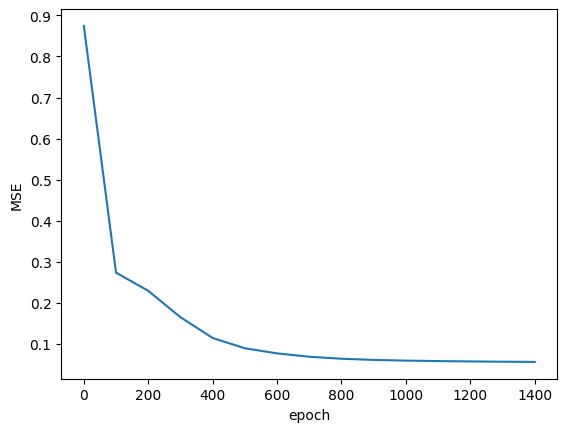

In [8]:
losses = []
for i in range(1500):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start:end])
        yy = torch.FloatTensor(Y[start:end])
        
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

plt.plot(np.arange(len(losses)) * 100, losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

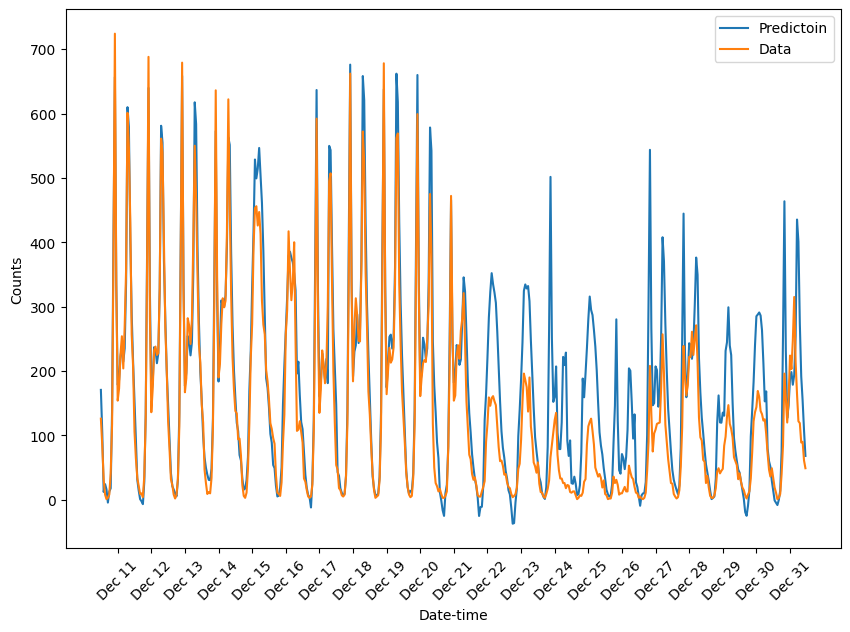

In [9]:
# 测试神经网络
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets), 1])

x = torch.FloatTensor(test_features.values)
y = torch.FloatTensor(targets)

# 用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()

fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Predictoin')  # 还原成真实值
ax.plot(targets * std + mean, label='Data')

ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24]) # 间隔24
ax.set_xticklabels(dates[12::24], rotation=45)

plt.show()

In [75]:
# 剖析神经网络neu
def feature(X, net):
    X = torch.from_numpy(X).type(torch.FloatTensor)
    dic = dict(net.named_parameters())

    weights = dic['0.weight'] #层数.名称
    biases = dic['0.bias']
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)]))
    return h

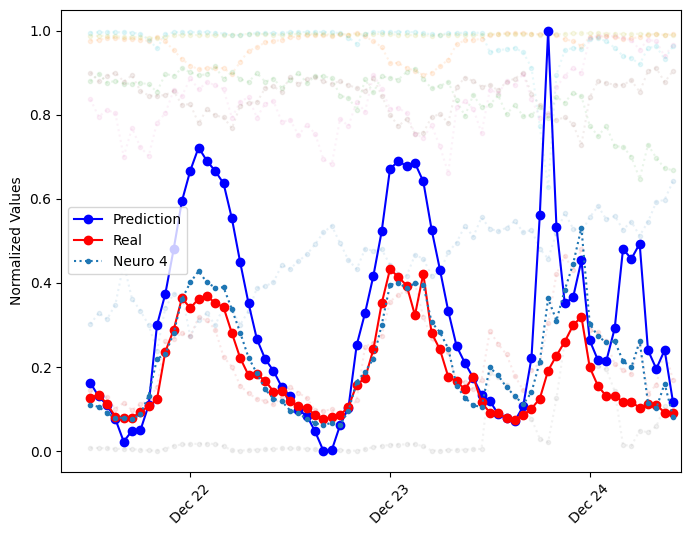

In [76]:
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

bools = [any(tup) for tup in zip(bool1, bool2, bool3) ]
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets), 1])

# 隐含层的计算
results = feature(subset.values, neu).data.numpy()
# 预测结果
predict = neu(torch.FloatTensor(subset.values)).data.numpy()
mean, std = scaled_features['cnt'] # 还原真实数据
predict = predict * std + mean
subtargets = subtargets * std + mean

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(results, '.:', alpha = 0.1)
ax.plot((predict - min(predict)) / (max(predict) - min(predict)), 'bo-', label = 'Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)), 'ro-', label = 'Real')
ax.plot(results[:,4], '.:', alpha = 1, label = 'Neuro 4')

ax.set_xlim(right=len(predict))
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24]) # 间隔24
ax.set_xticklabels(dates[12::24], rotation=45)

plt.show()

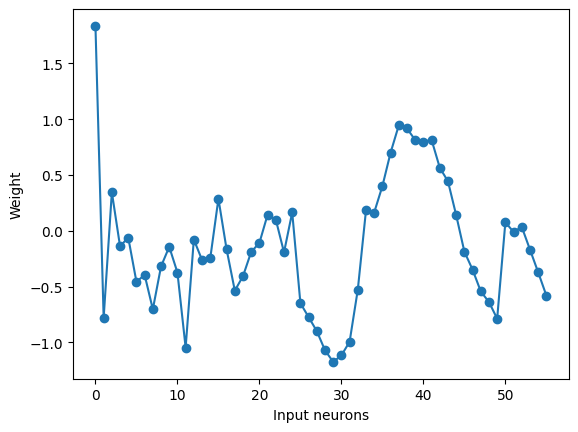

In [81]:
# 对某个神经元的权重进行可视化
dic = dict(neu.named_parameters())
weights = dic['0.weight']

plt.plot(weights.data.numpy()[4, :], 'o-')
plt.xlabel('Input neurons')
plt.ylabel('Weight')
plt.show()